In [2]:
import os
import groq

In [3]:
from Analysist_React_Agent.analyzer import SystemAnalyzer

In [4]:
os.environ["GROQ_API_KEY"] = "api"
os.environ["OPENROUTER_API_KEY"] = "api"

# Agent

In [5]:
class Validator_Agent:
    def __init__(self, model):
        self.agent = groq.Groq(
            api_key=os.environ.get("GROQ_API_KEY"),
        )
        self.model = model

    # Testing với Analysist Agent
    # Agent sẽ nhận vào state của graph, trong đó có các actors, functions và relationships đã được tạo bởi Analysist Agent
    # Trả về một chuỗi kết quả, trong đó có các actors, functions và relationships bị thiếu hoặc không hợp lệ
    def __call__(self, state):
        return self.agent.chat.completions.create(
            messages=[
                {
                    "role": "system",
                    "content":  """
                                You are a validator agent. Your task is to validate the list of actors, functions and relationships
                                created by the analyst agent with the system spec.
                                You will check if any actors, functions or relationship are missing.
                                For relationships, will check if it is a valid relationship and if its actor and target are correct.
                                Your output should follow this format:
                                Missing Actors: [list of missing actors]
                                Missing Functions: [list of missing functions] 
                                Missing Relationships: [list of missing relationships]
                                Invalid Relationships: [list of invalid relationships]
                                Relationships with wrong actors: [list of relationships with wrong actors]
                                Relationships with wrong targets: [list of relationships with wrong targets]
                                """,
                },
                {
                    "role": "user",
                    "content": f"""
                                System Specification: {state["specification"]}
                                Actors: {state["actors"]}
                                Functions: {state["functions"]}
                                Relationships: {state["relationships"]}
                                """,
                }
            ],
            model=self.model,
        ).choices[0].message.content

# Langgraph

In [6]:
from typing_extensions import TypedDict

# State của graph, đóng vai trò là một csdl tạm thời, chứa ngữ cảnh của graph, các agent có thể truy cập và sửa đổi
class State(TypedDict):
    specification: str
    actors: list[str]
    functions: list[str]
    relationship: list[str]

In [7]:
model = "llama-3.3-70b-versatile"
analyzer = SystemAnalyzer()
validator = Validator_Agent(model)

In [8]:
from langgraph.graph import StateGraph, START, END

# Xây dựng graph
graph_builder = StateGraph(State)

# Thêm các node vào graph
graph_builder.add_node("analysist_agent", lambda state: analyzer.analyze(state))
graph_builder.add_node("validator_agent", lambda state: validator(state))

# Kết nối các node trong graph
graph_builder.add_edge(START, "analysist_agent")
graph_builder.add_edge("analysist_agent", "validator_agent")
graph_builder.add_edge("validator_agent", END)

In [9]:
graph = graph_builder.compile()

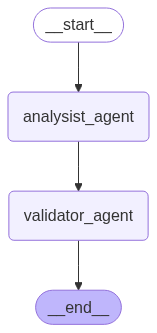

In [10]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [11]:
spec = """
Users can register accounts, log in, and edit personal information.
Administrators can approve new users, block offending accounts.
Both can create posts, comment, and rate other posts.
"""

In [12]:
# result = graph.invoke({"specification": spec})
# for stage in result:
#     print(result[stage])